As a dual to growing netwotks using evolutionary strategies, can we shrink an over-parametrized network to its optimal structure? The idea would be to fully utilize the parallel computational architecture on hand by training a network that maximizes the throughput of the GPU. Then, iteratively shrink and prune the network.

- Create an over-parametrized or rightly-parametrized network to optimally train the network.
- Inspect each layer and remove layers that are not having an impact on the outcome of the network.
- Layer-wise, apply strong L0 regularization to sparsify the layers.(or something more clever?)
- Recognize motiffs that develop in the network (for example, a chain of neurons that are stretching and splitting the parameter space) and interpret these motiffs as interpretable rules.


Each layer is creating a linear projection of the previous layer, and then cutting (activation function) at some point along each dimension.
Are there (possibly overlapping) subsets of units on each layer that could be grouped together? What are these sets of units doing in terms of the input space? Would an information metric work here?

After network compaction, would it be possible to identify rules that influence the output, for example:

1. Project input neurons $X_1$, $X_3$, and $X_{45}$ using this linear transformation $\Beta_1$. Then, cut the output of this along dimensions 2 and 3 at this value. Call this $T_1$
2. Project input neurons $X_2$, $X_{17}$, and $X_{10}$ using this other linear transformation $\Beta_2$. Then, cut the output of this along dimension 1 at this value. Call this $T_2$
3. Add $T_1$ and $T_2$ and extract this dimension as $Y$.

In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
from dmp.data.pmlb import pmlb_loader
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

import sys
sys.path.append("..")
from networks import get_basic_xor

from viz import *

In [61]:
centroids = [(0,0,0), (0,1,1), (1,0,1), (1,1,0)]
covariance = np.diag([0.005, 0.005])
n_data_points = 2000

def get_clusters():
    for centroid in centroids:
        x,y,z = centroid
        a = np.empty(shape=(int(n_data_points/4),3), dtype="float")
        a[:,0:2] = np.random.multivariate_normal([x,y], covariance, size=(int(n_data_points/4)))
        a[:,2] = z
        yield a

data = np.concatenate(list(get_clusters()))
inputs = data[:,0:2]
outputs = data[:,2:3]

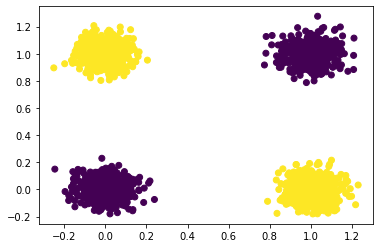

In [62]:
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0])

In [63]:
num_observations = inputs.shape[0]
num_inputs = inputs.shape[1]
num_outputs = outputs.shape[1]

hidden_layer_width=5
num_hidden_layers=5

layers = [ tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu, input_shape=(num_inputs,))]
for i in range(num_hidden_layers-1):
    layers.append( tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu))
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

model = tf.keras.Sequential(layers)

model.compile(
# loss='binary_crossentropy', # binary classification
# loss='categorical_crossentropy', # categorical classification (one hot)
loss='mean_squared_error',  # regression
optimizer=tf.keras.optimizers.Adam(0.001),
# optimizer='rmsprop',
# metrics=['accuracy'],
)

model.fit(
    x=inputs,
    y=outputs,
    shuffle=True,
    validation_split=.2,
    epochs=100,
    batch_size=128,
    )

Epoch 1/100
13/13 [==============================] - 0s 12ms/step - loss: 0.5172 - val_loss: 0.0170
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4430 - val_loss: 0.0430
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.3772 - val_loss: 0.0848
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.2969 - val_loss: 0.1483
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.2432 - val_loss: 0.2265
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.2007 - val_loss: 0.3100
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1747 - val_loss: 0.3803
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1596 - val_loss: 0.4279
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1483 - val_loss: 0.4506
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1375 - val_loss: 0.4473
Epoch 11

In [64]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_77 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_78 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_79 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_______________________________________________________

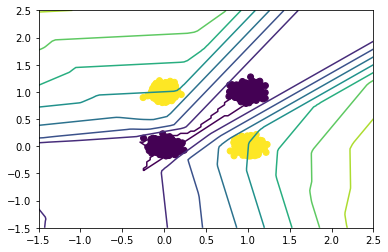

In [65]:
y_pred = model.predict(inputs[:,0:2])

X = np.linspace(0.5-2,0.5+2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z)
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0])

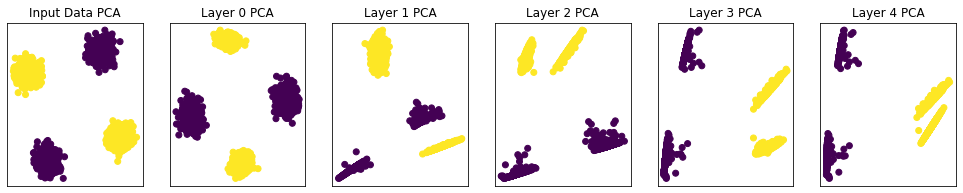

In [66]:
print_layer_pca(model, inputs, outputs)

In [49]:
old_layers = model.layers.copy()
del old_layers[2:5]


layers = [
    tf.keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(2,)),
    tf.keras.layers.Dense(5, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)]

model_2 = tf.keras.Sequential(layers)

layers[0].set_weights(old_layers[0].get_weights())
layers[1].set_weights(old_layers[1].get_weights())
layers[2].set_weights(old_layers[2].get_weights())


In [50]:
model_2.compile(
        # loss='binary_crossentropy', # binary classification
        # loss='categorical_crossentropy', # categorical classification (one hot)
        loss='mean_squared_error',  # regression
        optimizer=tf.keras.optimizers.Adam(0.001),
        # optimizer='rmsprop',
        # metrics=['accuracy'],
        )


model_2.fit(
    x=inputs,
    y=outputs,
    shuffle=True,
    validation_split=.2,
    # epochs=12,
    epochs=100,
    batch_size=256,
    )

Epoch 1/100
7/7 [==============================] - 0s 42ms/step - loss: 0.2585 - val_loss: 0.2634
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2518 - val_loss: 0.2675
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2433 - val_loss: 0.2720
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2414 - val_loss: 0.2764
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2345 - val_loss: 0.2812
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2292 - val_loss: 0.2859
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2256 - val_loss: 0.2906
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.2196 - val_loss: 0.2954
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.2102 - val_loss: 0.2999
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2076 - val_loss: 0.3043
Epoch 11/100
7/7 [==========

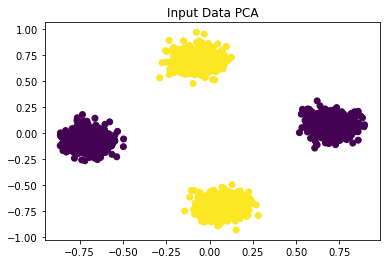

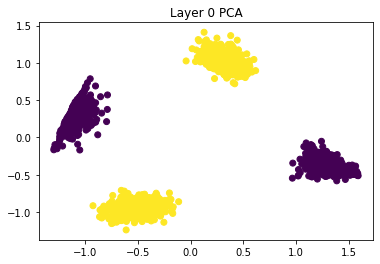

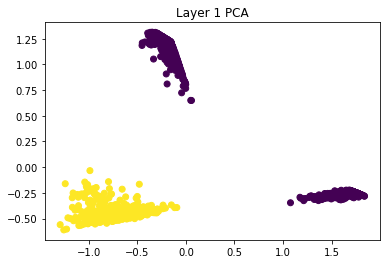

In [51]:
print_layer_pca(model_2, inputs, outputs)

In [52]:
model_2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


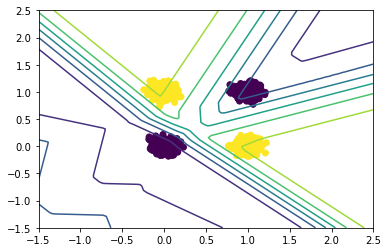

In [55]:
y_pred = model_2.predict(inputs[:,0:2])

X = np.linspace(0.5-2,0.5+2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = model_2.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z)
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0])

Perhaps this representation supports better extrapolation? Since there is not an arbitrary cut-off for the 0,0 centroid off to the lower left. It is correctly classified out to infinity. I wonder if regularization supports this?

In [56]:
old_layers = model_2.layers.copy()

layers = [
    tf.keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(2,), kernel_regularizer=tf.keras.regularizers.l1(1e-5)),
    tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(1e-5)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=tf.keras.regularizers.l1(1e-5))]

model_3 = tf.keras.Sequential(layers)

layers[0].set_weights(old_layers[0].get_weights())
layers[1].set_weights(old_layers[1].get_weights())
layers[2].set_weights(old_layers[2].get_weights())


model_3.compile(
        # loss='binary_crossentropy', # binary classification
        # loss='categorical_crossentropy', # categorical classification (one hot)
        loss='mean_squared_error',  # regression
        optimizer=tf.keras.optimizers.Adam(0.001),
        # optimizer='rmsprop',
        # metrics=['accuracy'],
        )


model_3.fit(
    x=inputs,
    y=outputs,
    shuffle=True,
    validation_split=.2,
    # epochs=12,
    epochs=200,
    batch_size=256,
    )

Epoch 1/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0157 - val_loss: 0.0788
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss: 0.0760
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.0732
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0702
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0663
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0624
Epoch 7/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0111 - val_loss: 0.0580
Epoch 8/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0545
Epoch 9/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0092 - val_loss: 0.0510
Epoch 10/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0092 - val_loss: 0.0487
Epoch 11/200
7/7 [==========

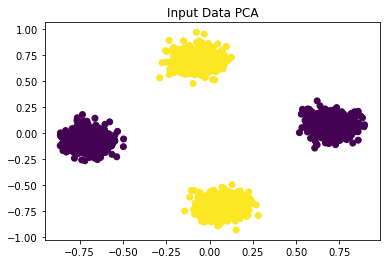

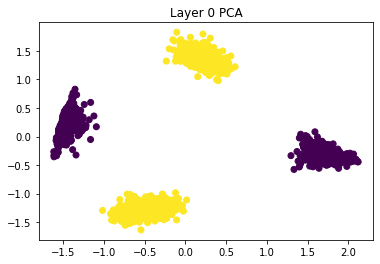

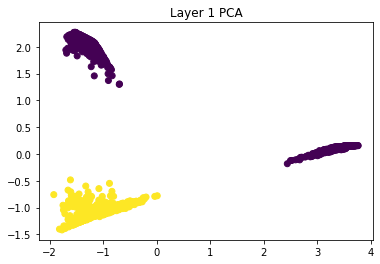

In [57]:
print_layer_pca(model_3, inputs, outputs)

In [58]:
model_3.layers[0].get_weights()

[array([[-1.90356016e+00,  1.85347861e-04,  1.56207788e+00,
          1.29755330e+00,  4.32849705e-01],
        [ 1.27529407e+00, -1.44622245e-05,  1.58121514e+00,
         -1.35025048e+00, -1.62378836e+00]], dtype=float32),
 array([ 0.6026972 , -0.16469967, -0.12955385, -0.0216086 ,  1.1119328 ],
       dtype=float32)]

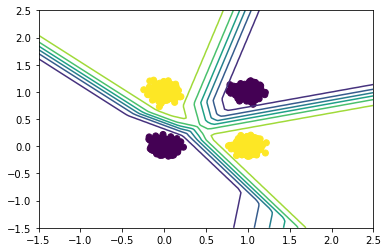

In [59]:
y_pred = model_3.predict(inputs[:,0:2])

X = np.linspace(0.5-2,0.5+2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = model_3.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z)
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0])

## Clustering the activations of units within important layers

In [40]:
model.layers[1]

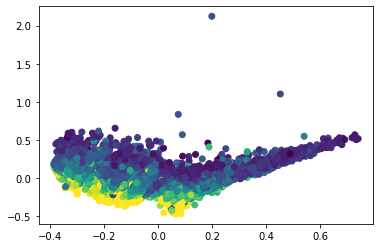

NameError: name 'sns' is not defined

In [50]:
keras_function = tf.keras.backend.function([model.input], [model.layers[1].output])
layerwise_activation = keras_function([inputs])

pca = PCA(6)
out = pca.fit_transform(layerwise_activation[0])
plt.scatter(out[:,0], out[:,1], c=outputs)
plt.show()

sns.heatmap(pca.components_)

/Users/jperrsau/opt/anaconda3/envs/dmp/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


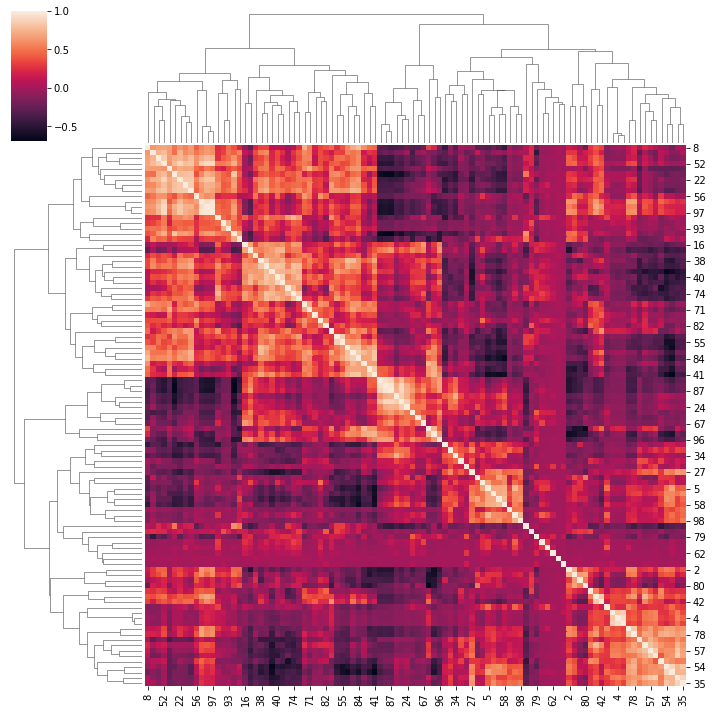

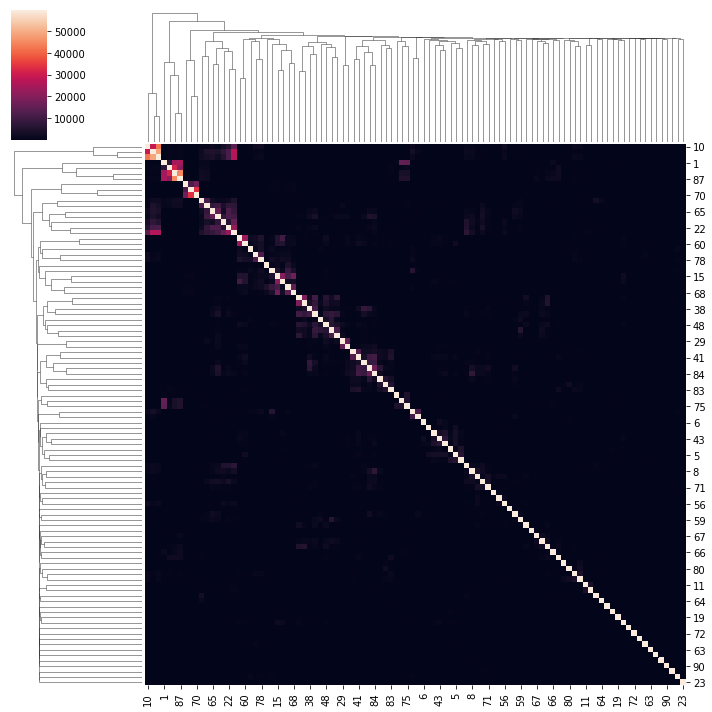

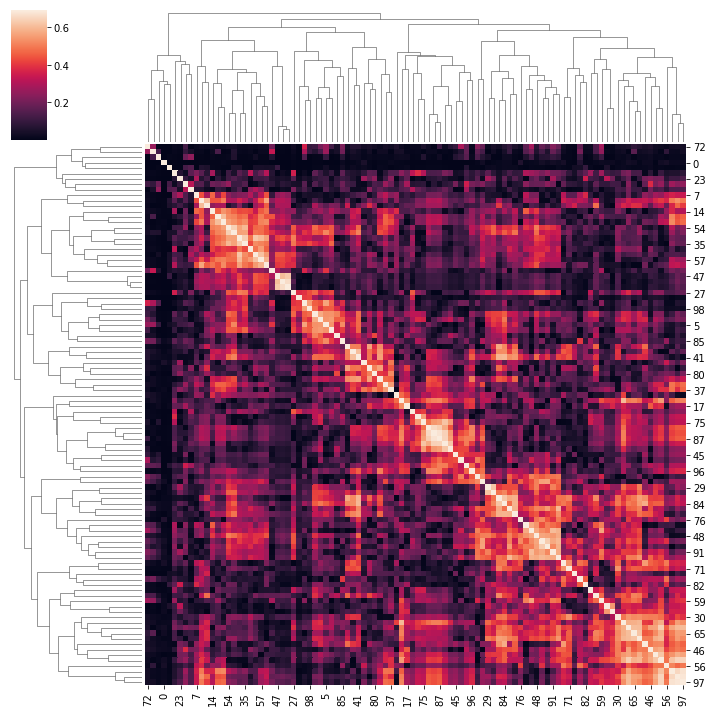

In [104]:
nonzero_std = [np.std(layerwise_activation[0], axis=0) != 0]
cor = np.corrcoef(layerwise_activation[0].T[tuple(nonzero_std)])
sns.clustermap(cor)
sns.clustermap(np.exp(1+10*np.abs(cor)))
sns.clustermap(np.log1p(np.abs(cor)))

In [102]:
## We want to enable overlapping clusters
## Can we preserve only one unit from each correlated cluster?

In [36]:
## Using simpler XOR network

model, inputs, outputs = get_basic_xor()

NameError: name 'get_basic_xor' is not defined

In [ ]:
# Relation to reservoir computing

# Generate powerset of units in layer and visualize the PCA of that

# Train smaller network on piece of the network

# Basic rule extraction

From a deep neural network $F$, we'd like to extract a formula $f$ such that $Y=F(X) \implies Y=f(X)$. Furthermore, we'd like this formula to be meaningful to humans and fast to compute.

Representations of formulas:
- List of rules.
- Expression.
    - Boolean, real.
- Program.

Procedures to extract formula from deep nn:
- Trivial: Direct conversion.
- Simplify and convert.
- Convert and simplify.
- Mixture conversion (evolutionary?)




